# Introducción

Esta es una implementación de un modelo de aprendizaje profundo para la clasificación de imágenes de radiografías de tórax en dos categorías: Neumonía y Normal. El conjunto de datos utilizado se origina en el Centro Médico de Mujeres y Niños de Guangzhou, y comprende 5,863 imágenes de rayos X de pacientes pediátricos, organizadas en conjuntos de entrenamiento, prueba y validación.

La neumonía, especialmente en niños menores de 5 años, es una enfermedad común y potencialmente mortal, por lo que la detección temprana es crucial. Un modelo de aprendizaje profundo puede mejorar la velocidad y precisión del diagnóstico, siendo una herramienta valiosa para los profesionales médicos.

## Preparación

Esta sección configurará nuestro entorno, montará Google Drive y se conectará a Kaggle.

In [1]:
# Se importan las librerias principales para un modelo de deep learning.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_sample_image

# Se hace una configuración específica que permite mostrar gráficos en línea.
%matplotlib inline

In [ ]:
# Importa lo necesario para montar Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Se elige el directorio donde se va a guardar el dataset.
%cd /content/drive/MyDrive/semestre_7/blumenkron/RetroDL

/content/drive/MyDrive/semestre_7/blumenkron/RetroDL


In [ ]:
# Se obtiene el API de kaggle y se sube.
from google.colab import files
files.upload()

{}

In [ ]:
# Se le otorgan los permisos necesarios.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Se comprueba que todo esta funcionando de forma correcta.
!kaggle datasets list

ref                                                           title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset            Customer Shopping Trends Dataset                146KB  2023-10-05 06:45:37          23944        487  1.0              
carlmcbrideellis/llm-7-prompt-training-dataset                LLM: 7 prompt training dataset                   31MB  2023-11-08 07:47:40            363         47  1.0              
bryanchungweather/nba-player-stats-dataset-for-the-2023-2024  NBA Player Stats Dataset for the 2023-2024       21KB  2023-11-14 03:53:32            619         26  1.0              
joebeachcapital/30000-spotify-songs                           30000 Spotify Songs         

In [ ]:
# Se descarga el dataset Chest X-Ray Images (Pneumonia).
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
# Se descomprime el archivo 'chest-xray-pneumonia.zip'.
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N
N


Despues de que descargar y descomprimir los datos que venian en el dataset, nos encontramos con esta estructura en la carpeta:

```
chest_xray/
...test/
...train/         
...val/         
```

Una de las cosas de las que nos podemos dar cuenta es que la informacion ya esta dividida en entrenamiento, validacion y prueba, por lo que ya no sera necesario que lo hagamos nosotros.

# Datos.
Ya que los datos ya estan separados en conjuntos de entrenamiento, validacion y prueba, vamos a revisar el contenido de uno de los conjuntos para ver con el tipo de datos con los que vamos a trabajar.

In [3]:
# Se definen las rutas que se van a estar utilizando.
test_folder = '/content/drive/MyDrive/semestre_7/blumenkron/RetroDL/chest_xray/chest_xray/test'
train_folder = '/content/drive/MyDrive/semestre_7/blumenkron/RetroDL/chest_xray/chest_xray/train'
val_folder = '/content/drive/MyDrive/semestre_7/blumenkron/RetroDL/chest_xray/chest_xray/val'

In [4]:
# Se definen las rutas de las carpetas 'Normal' y 'Neumonia' para train.
train_nor = train_folder + '/NORMAL/'
train_neu = train_folder + '/PNEUMONIA/'

In [5]:
# Se selecciona una imagen 'Normal' aleatoria del conjunto train.
nor_rand = np.random.randint(0, len(os.listdir(train_nor)))
nor_num_foto = os.listdir(train_nor)[nor_rand]
nor_foto = train_nor + nor_num_foto

In [6]:
# Se selecciona una imagen 'Neumonia' aleatoria del conjunto train.
neu_rand = np.random.randint(0, len(os.listdir(train_neu)))
neu_num_foto = os.listdir(train_neu)[neu_rand]
neu_foto = train_neu + neu_num_foto

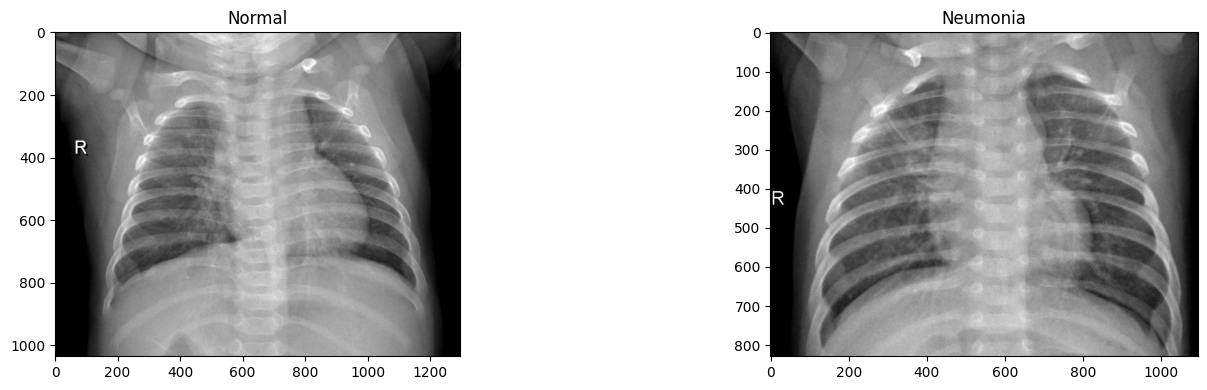

Foto Normal : IM-0575-0001.jpeg
Foto Neumonia: person1490_virus_2596.jpeg


In [7]:
# Se cargan las dos imagenes.
nor_img = plt.imread(nor_foto)
neu_img = plt.imread(neu_foto)

# Se configura el tamaño de la figura.
plt.figure(figsize=(16, 4))

# Se genera el subgrafico para la imagen 'Normal'.
plt.subplot(1, 2, 1)
plt.imshow(nor_img, cmap='gray')
plt.title('Normal')

# Se genera el subgrafico para la imagen 'Neumonia'.
plt.subplot(1, 2, 2)
plt.imshow(neu_img, cmap='gray')
plt.title('Neumonia')

# Se ajusta el diseño para evitar solapamientos.
plt.tight_layout()

# Se muestra la figura.
plt.show()

# Se imprime la información sobre las rutas de las imágenes.
print(f"Foto Normal : {nor_foto[88:]}")
print(f"Foto Neumonia: {neu_foto[91:]}")

Las imágenes anteriores se generan aleatoriamente a partir del conjunto de datos ya mencionado. Podemos notar que hay pequeñas diferencias entre las imagenes Normales y de Neumonia. Las principales diferencias es que en las imagenes con Neumonia nos encontramos con un aumento en la radioopacidad.

# Desarrollo del modelo.

Para el desarrollo del modelo se implementará un CNN con dos capas de convolución. Después de cada operación de convolución, se incorporará una capa de pooling utilizando la técnica de max-pooling.

Como estamos trabajando con un problema de clasificacion binaria es importante destacar que la salida consistirá en una única capa densa con una unidad y una función de activación sigmoide, ya que su tarea específica es predecir la presencia de neumonía en la imagen.

Por ultimo, para la compilación de nuestro modelo, se empleará la función de optimización Adam.

In [20]:
# Se importan las librerias necesarias.
from tensorflow import keras
from keras import layers

# Se crea un modelo secuencial.
model = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(64, 64, 3)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Se muestra un resumen del modelo.
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 6272)              0         
                                                                 
 dense_7 (Dense)             (None, 128)              

In [21]:
# Se compila el modelo.
model.compile(
    loss = 'binary_crossentropy', optimizer = 'adam',  metrics = ['accuracy'])

In [22]:
# Se importan las librerias necesarias.
from keras.preprocessing.image import ImageDataGenerator

# Se crea un generador de datos.
datagen = ImageDataGenerator(rescale=1./255)

In [23]:
# Se configura el generador de datos para el conjunto de prueba.
test_generador = datagen.flow_from_directory(
    test_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

# Se configura el generador de datos para el conjunto de entrenamiento.
train_generador = datagen.flow_from_directory(
    train_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

# Se configura el generador de datos para el conjunto de validación.
val_generador = datagen.flow_from_directory(
    val_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [24]:
# Se configura un callback para guardar el mejor modelo durante el entrenamiento.
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch", save_best_only=True, monitor="val_loss")]

# Se entrena el modelo.
history = model.fit(train_generador, epochs=6,
                    validation_data=val_generador, callbacks=callbacks)

Epoch 1/6
163/163 [==============================] - 63s 342ms/step - loss: 0.2688 - accuracy: 0.8892 - val_loss: 0.2359 - val_accuracy: 0.8750
Epoch 2/6
163/163 [==============================] - 54s 335ms/step - loss: 0.1111 - accuracy: 0.9565 - val_loss: 0.3268 - val_accuracy: 0.9375
Epoch 3/6
163/163 [==============================] - 58s 353ms/step - loss: 0.0878 - accuracy: 0.9686 - val_loss: 0.1433 - val_accuracy: 0.9375
Epoch 4/6
163/163 [==============================] - 54s 332ms/step - loss: 0.0813 - accuracy: 0.9716 - val_loss: 0.1580 - val_accuracy: 0.9375
Epoch 5/6
163/163 [==============================] - 54s 334ms/step - loss: 0.0748 - accuracy: 0.9722 - val_loss: 0.2450 - val_accuracy: 0.9375
Epoch 6/6
163/163 [==============================] - 60s 366ms/step - loss: 0.0623 - accuracy: 0.9747 - val_loss: 0.2046 - val_accuracy: 0.9375


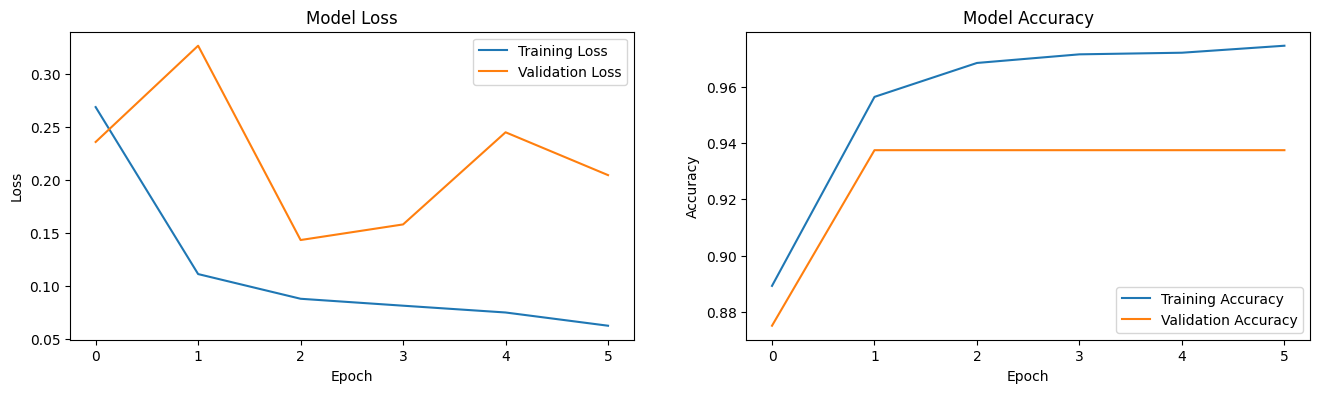

In [25]:
# Se configura el tamaño de la figura.
plt.figure(figsize=(16, 4))

# Se genera el subgrafico para la grafica de perdida.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Se genera el subgrafico para la grafica de precisión.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Se muestran los graficos.
plt.show()

De acuerdo con los resultados se puede determinar que hay un problema de overfitting en el modelo.

Esto se puede observar en la precisión de el conjunto de entrenamiento el cual es considerablemente mayor que en el de validacion. Por otro lado, la perdida en el conjunto de entrenamiento es baja a diferencia de la del conjunto de validación la cual se encuentra considerablemente mas alta en algunas epocas.

In [26]:
# Se evalua el modelo en el conjunto de prueba.
test_loss, test_acc = model.evaluate(test_generador)

# Se muestran la perdida y la precisión en el conjunto de prueba.
print(f"Perdida en el test set: {test_loss}")
print(f"Precisión en el test set: {test_acc}")

20/20 [==============================] - 6s 311ms/step - loss: 1.0496 - accuracy: 0.7788
Perdida en el test set: 1.0495771169662476
Precisión en el test set: 0.7788461446762085


En la evaluacion se puede observar que la pérdida y la precisión en el conjunto de prueba son moderadas, pero que no son tan buenas como las métricas en el conjunto de entrenamiento.

# Ajuste del modelo.

Como vimos en las graficas anteriores el modelo cuenta con un problema de overfitting. El overfitting puede deberse a una cantidad insuficiente de datos de entrenamiento, por lo que hay que usar tecnicas para poder combatir este problema.

Para este problema vamos a utilizar la incorporación de técnicas de data augmentation, como cortes, cambio de zoom, etc. las cuales generan variabilidad en nuestros datos de entrenamiento, ayudando al modelo a generalizar mejor a datos no vistos.

In [27]:
# Se configuran los datos del Data Augmentation.
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Se configurar el generador de datos de entrenamiento con Data Augmentation.
train_generador_augmented = train_datagen.flow_from_directory(
    train_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [28]:
# Se compila el modelo nuevamente después de aplicar el Data Augmentation.
model.compile(
    loss = 'binary_crossentropy', optimizer = 'adam',  metrics = ['accuracy'])

# Se entrena el modelo con el generador de datos de entrenamiento aumentado.
history_augmented = model.fit(
    train_generador_augmented,
    epochs=11,
    validation_data=val_generador,
)


Epoch 1/11
163/163 [==============================] - 71s 407ms/step - loss: 6.1939 - accuracy: 0.8560 - val_loss: 0.6810 - val_accuracy: 0.5000
Epoch 2/11
163/163 [==============================] - 65s 398ms/step - loss: 0.3723 - accuracy: 0.8894 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/11
163/163 [==============================] - 73s 447ms/step - loss: 0.3094 - accuracy: 0.9005 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 4/11
163/163 [==============================] - 62s 380ms/step - loss: 0.2457 - accuracy: 0.9122 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 5/11
163/163 [==============================] - 64s 392ms/step - loss: 0.2248 - accuracy: 0.9220 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 6/11
163/163 [==============================] - 64s 393ms/step - loss: 0.2233 - accuracy: 0.9191 - val_loss: 0.6972 - val_accuracy: 0.5000
Epoch 7/11
163/163 [==============================] - 67s 411ms/step - loss: 0.2218 - accuracy: 0.9199 - val_loss: 0.6991 - val_ac

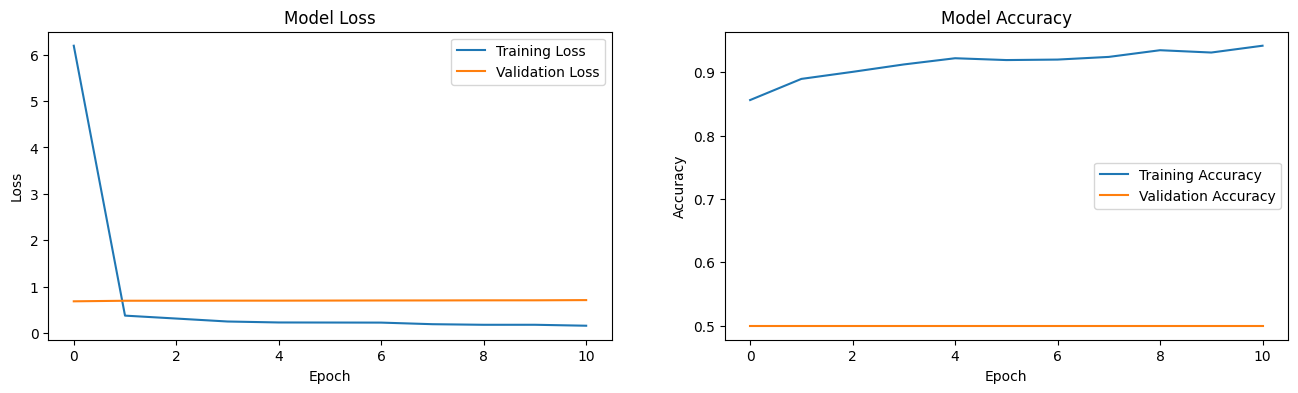

In [29]:
# Se configura el tamaño de la figura.
plt.figure(figsize=(16, 4))

# Se genera el subgrafico para la grafica de perdida.
plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['loss'], label='Training Loss')
plt.plot(history_augmented.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Se genera el subgrafico para la grafica de precisión.
plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['accuracy'], label='Training Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Se muestran los graficos.
plt.show()

# Resultados.

 A continuacion vamos a realizar algunas predicciones utilizando el modelo entrenado.

1/1 [==============================] - 0s 241ms/step


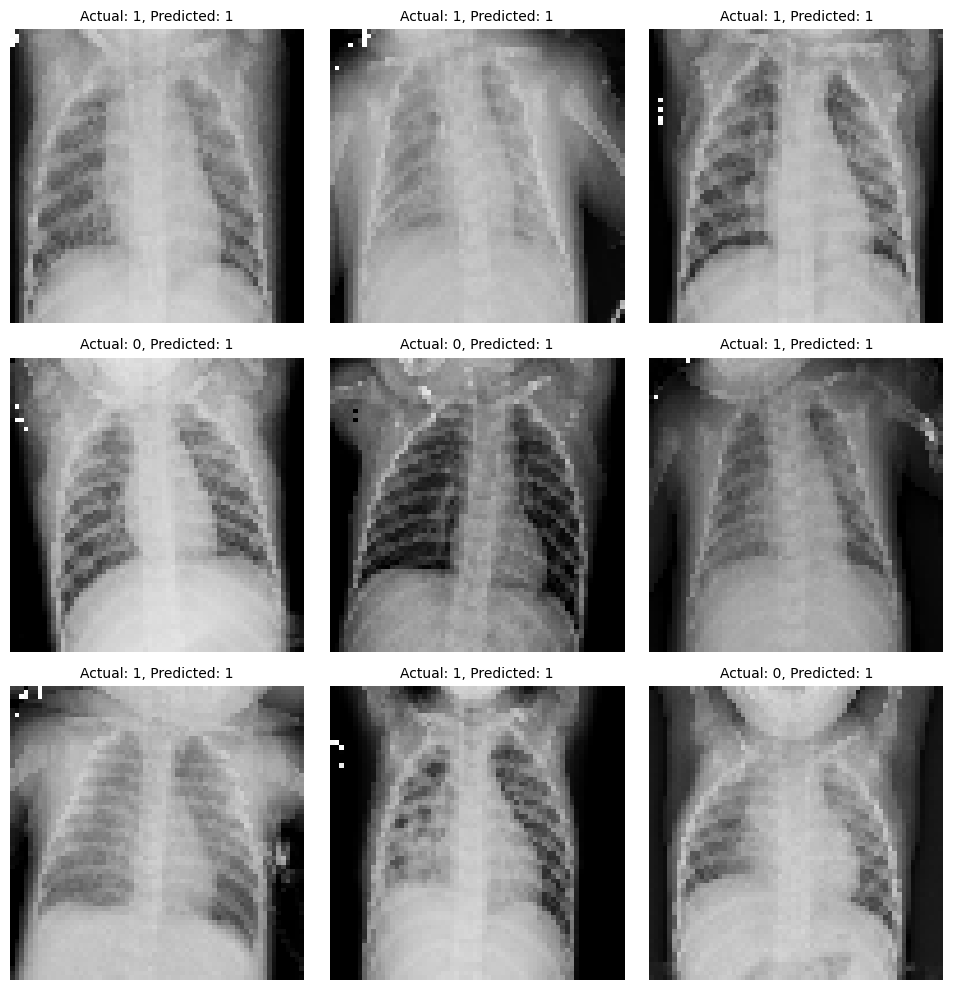

In [30]:
prediction = model.predict(val_generador)

prediction_labels = []
for i in prediction:
    if i > 0.5:
        prediction_labels.append(1)
    else:
        prediction_labels.append(0)

images, labels = val_generador.next()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(f"Actual: {val_generador.class_indices['PNEUMONIA' if labels[i] == 1 else 'NORMAL']}, Predicted: {prediction_labels[i]}", fontsize=10)
    plt.axis(False)
    plt.tight_layout()

plt.show()


# Conclusiones.

Aunque el modelo inicial mostró buenos resultados en el conjunto de entrenamiento, se observó un problema de overfitting al evaluarlo en el conjunto de validación. Para abordar este problema, se aplicaron técnicas de aumento de datos, como cortes, cambio de zoom y volteo horizontal.

A pesar de abordar este problema con data augmentation, otras posible mejora puede ser la contruccion de una arquitectura de modelo más compleja, ajustes adicionales en los hiperparámetros del modelo, etc.

Además, la expansión del conjunto de datos o la búsqueda de conjuntos de datos adicionales podrían contribuir a una mejora significativa en la generalización del modelo.
